In [1]:
import tensorflow as tf
import time
from lstm_evaluator import LSTMEvaluator
from datetime import datetime
import os

2025-03-24 18:31:07.248941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-24 18:31:08.480968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### VISUALISE THE TRAINING

In [8]:
pwd

'/home/docker/data/masters_work/segmentation-models/se2seq_segmentation_models/data_augmented_models/lstm_based_models'

Saved training history inspection for segmenter_one at segmenter_one/training_history_inspection.csv
Saved training history inspection for segmenter_two at segmenter_two/training_history_inspection.csv
Saved training history inspection for segmenter_three at segmenter_three/training_history_inspection.csv


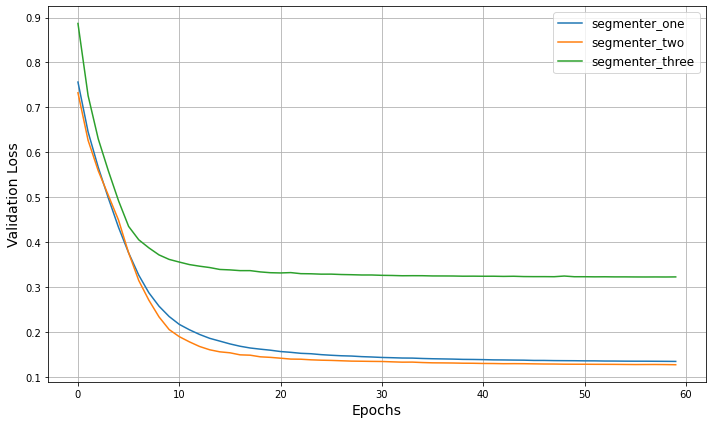

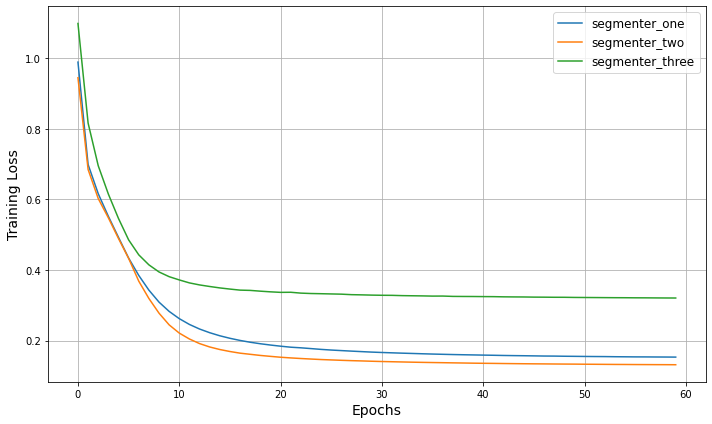

In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Define the segmenter names
segmenter_names = ["segmenter_one", "segmenter_two", "segmenter_three"]

# Initialize dictionaries to store data
train_losses = {}
val_losses = {}

# Iterate through each segmenter and process training history
for segmenter in segmenter_names:
    model_dir = Path(f"{segmenter}")
    history_path = model_dir / "training_history.npy"
    inspection_csv_path = model_dir / "training_history_inspection.csv"
    
    if history_path.exists():
        loaded_history = np.load(history_path, allow_pickle=True).item()
        
        history_df = pd.DataFrame(loaded_history)
        
        # Save as CSV for inspection
        history_df.to_csv(inspection_csv_path, index=False)
        print(f"Saved training history inspection for {segmenter} at {inspection_csv_path}")
        
        # Store training and validation losses
        train_losses[segmenter] = history_df['loss'].tolist()
        val_losses[segmenter] = history_df['val_loss'].tolist()
    else:
        print(f"Training history not found for {segmenter} at {history_path}")

# Plot Validation Loss for all models in one graph
plt.figure(figsize=(10, 6))
for segmenter, losses in val_losses.items():
    plt.plot(range(len(losses)), losses, label=f'{segmenter}')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("segmenters_validation_loss_plot.png")
plt.show()

# Plot Training Loss for all models in one graph
plt.figure(figsize=(10, 6))
for segmenter, losses in train_losses.items():
    plt.plot(range(len(losses)), losses, label=f'{segmenter}')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("segmenters_training_loss_plot.png")
plt.show()

In [20]:
def save_model_comparison(model_base_path: str, model_names: list):
    """
    Compare multiple trained LSTM models based on evaluation metrics.
    
    Args:
        model_base_path (str): Base path containing all model directories
        model_names (list): List of model names to evaluate
        
    Returns:
        pd.DataFrame: DataFrame containing evaluation results for all models
    """
    results = []  # List to store results
    
    for model_name in model_names:
        print(f"\nEvaluation of {model_name}")
        print("=" * 50)
        start_time = time.time()
        
        try:
            # Initialize evaluator
            evaluator = LSTMEvaluator(
                model_path=model_base_path,
                model_name=model_name
            )
            
            # Run evaluation and unpack all returned values
            print("Evaluating the model...")
            results_dict, predicted, targeted = evaluator.get_predictions_from_file()
                        
            # Save individual model results with all required parameters
            evaluator.save_results(results_dict, predicted, targeted)
            
            result = {
                'model_name': model_name,
                'position_precision': results_dict['position_scores']['precision'],
                'position_recall': results_dict['position_scores']['recall'],
                'position_f1': results_dict['position_scores']['f1'],
                'bleu_scores': results_dict['bleu_scores']['equal'],
                'chrf': results_dict['chrf_score'],
                'num_predictions': len(predicted),
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }
            results.append(result)

            # Print individual model results
            print(f"\nResults for model: {result['model_name']}")
            print(f"Number of predictions: {result['num_predictions']}")
            print(f"Position Scores: Precision={result['position_precision']:.3f}, "
                  f"Recall={result['position_recall']:.3f}, F1={result['position_f1']:.3f}")
            print(f"BLUE Score={result['bleu_scores']:.4f}")
            print(f"chrF Score: {result['chrf']:.4f}")

            
            elapsed_time = time.time() - start_time
            formatted_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
            print(f"\nTotal evaluation time: {formatted_time}")
            
        except Exception as e:
            print(f"\nError during evaluation of {model_name}: {str(e)}")
            print("\nDebugging Information:")
            print(f"Current working directory: {os.getcwd()}")
            if os.path.exists(model_base_path):
                print(f"Contents of {model_base_path}:", os.listdir(model_base_path))
            continue
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(results)
    
    comparison_file = "lstm_model_comparison_results.csv"
    
    if os.path.exists(comparison_file):
        df.to_csv(comparison_file, mode='a', header=False, index=False)
    else:
        df.to_csv(comparison_file, index=False)
    
    print(f"\nComparison results saved to: {comparison_file}")
    
    # Create a formatted markdown table
    markdown_table = "# LSTM Model Comparison Results\n\n"
    markdown_table += df.to_markdown(index=False)
    
    with open("lstm_model_comparison_results.md", "w") as f:
        f.write(markdown_table)
    
    print(f"\nComparison markdown saved to: lstm_model_comparison_results.md")
    
    return df

In [21]:
if __name__ == "__main__":
    # Define model paths
    model_base_path = "."
    model_names = ["segmenter_one", "segmenter_two", "segmenter_three"]    
    try:
        results_df = save_model_comparison(model_base_path, model_names)
    except Exception as e:
        print(f"Error in main execution: {str(e)}")


Evaluation of segmenter_one
Evaluating the model...
Reading predictions from: ./segmenter_one/predictions/predictions_20250324_184208.csv
Original pairs: 20000
Valid pairs after filtering: 20000
Filtered out 0 pairs
Original pairs: 20000
Valid pairs after filtering: 20000
Filtered out 0 pairs
Successfully loaded 20000 predictions

Example predictions:

Example 1:
Target: uku-nga-shumayelel-i
Predicted: uku-nga-shumayelel-i

Example 2:
Target: e-dlal-e
Predicted: e-dlal-e

Example 3:
Target: o-nga-wu-z-i
Predicted: o-nga-wu-z-i

Saved evaluation metrics to ./segmenter_one/evaluation_results.txt
Saved predictions and targets to ./segmenter_one/predictions/predictions_20250324_184245.csv

Results for model: segmenter_one
Number of predictions: 20000
Position Scores: Precision=0.840, Recall=0.844, F1=0.842
BLUE Score=0.8497
chrF Score: 0.9081

Total evaluation time: 00:00:07

Evaluation of segmenter_two
Evaluating the model...
Reading predictions from: ./segmenter_two/predictions/predicti